# 끄적거리거나 테스트 하는 코드

## import modules

In [8]:
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
import torch.nn.functional as F

import random
import time
from datetime import timedelta

import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pytorch_model_summary import summary

from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

import multiprocessing
import timm

from PIL import Image

import os
import json

import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

In [46]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## 3head_train.csv 파일을 모델 3개로 inference하고 결과를 확인해봅시다

### dset

In [47]:
class CustomTrainDataset(Dataset):
    def __init__(self, 
                 img_paths : pd.Series, 
                 mask_labels : pd.Series, 
                 gender_labels:pd.Series, 
                 age_labels:pd.Series, 
                 transforms=None):
        self.img_paths = img_paths.to_numpy()
        self.transforms = transforms
        self.mask_labels = mask_labels.to_numpy() # self.labels = pd.get_dummies(labels).to_numpy()
        self.gender_labels = gender_labels.to_numpy()
        self.age_labels = age_labels.to_numpy(np.float32)
        assert self.transforms != None, 'you must use transforms in Trainset'
    
    ## return numpy img, label
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = np.array(Image.open(img_path))

        img = self.transforms(image=img)["image"]
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]

        return img, mask_label, gender_label, age_label

    def __len__(self):
        return len(self.img_paths)

In [48]:
csv_path = './dataset/train/3head_train.csv'
csv_file = pd.read_csv(csv_path)
csv_file

,Unnamed: 0,path,mask_class,gender_class,age,origin_label
0,0,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4
1,1,/opt/ml/repo/level1_imageclassification_cv-lev...,2,1,45,16
2,2,/opt/ml/repo/level1_imageclassification_cv-lev...,1,1,45,10
3,3,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4
4,4,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4
...,...,...,...,...,...,...
18895,18895,/opt/ml/repo/level1_imageclassification_cv-lev...,1,0,19,6
18896,18896,/opt/ml/repo/level1_imageclassification_cv-lev...,0,0,19,0
18897,18897,/opt/ml/repo/level1_imageclassification_cv-lev...,0,0,19,0
18898,18898,/opt/ml/repo/level1_imageclassification_cv-lev...,0,0,19,0


In [49]:
inference_transforms = A.Compose([A.Resize(224, 224),
                                  A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
                                  ToTensorV2()])
infer_dset = CustomTrainDataset(csv_file['path'], 
                                csv_file['mask_class'], 
                                csv_file['gender_class'], 
                                csv_file['age'], 
                                inference_transforms)

In [50]:
infer_loader = DataLoader(infer_dset,
                          batch_size=500,
                          num_workers=multiprocessing.cpu_count() // 2,
                          shuffle=False,
                          pin_memory=use_cuda,
                          drop_last=False)

### convnext_tiny, train_set inference score 

In [51]:
file_path = os.path.join(os.getcwd(),'checkpoints','convnext_tiny','best.pth')

In [ ]:
model = timm.create_model(model_name='convnext_tiny', pretrained=True, num_classes=18)
model.to(device)
model.load_state_dict(torch.load(file_path))

In [ ]:
test_preds = []
with torch.no_grad():
        for idx, dset in enumerate(infer_loader):
            images, _, _, _ = dset
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            test_preds.extend(pred.cpu().numpy().tolist())

In [ ]:
csv_file['one_model_pred'] = test_preds

In [ ]:
len(csv_file[csv_file['one_model_pred'] != csv_file['origin_label']])

26

In [ ]:
accuracy_score(csv_file['origin_label'],csv_file['one_model_pred'])

0.9986243386243386

In [ ]:
f1_score(csv_file['origin_label'],csv_file['one_model_pred'], average='macro')

0.9978974134742552

## 3 model, train_set inference score 

### mask model

In [ ]:
file_path = os.path.join(os.getcwd(),'checkpoints','eff_mask_cls','best.pth')

In [ ]:
model = timm.create_model(model_name='efficientnet_b4', pretrained=False, num_classes=3)
model.to(device)
model.load_state_dict(torch.load(file_path))

<All keys matched successfully>

In [ ]:
mask_preds = []
with torch.no_grad():
        for idx, dset in enumerate(infer_loader):
            images, _, _, _ = dset
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            mask_preds.extend(pred.cpu().numpy().tolist())

In [ ]:
csv_file['three_model_mask_pred'] = mask_preds

In [ ]:
f1_score(csv_file['mask_class'], csv_file['three_model_mask_pred'], average='macro')

0.993080176111708

### gender model

In [ ]:
file_path = os.path.join(os.getcwd(),'checkpoints','convnext_gender_cls','best.pth')

In [ ]:
model = timm.create_model(model_name='convnext_tiny', pretrained=False, num_classes=2)
model.to(device)
model.load_state_dict(torch.load(file_path))

<All keys matched successfully>

In [ ]:
gender_preds = []
with torch.no_grad():
        for idx, dset in enumerate(infer_loader):
            images, _, _, _ = dset
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            gender_preds.extend(pred.cpu().numpy().tolist())

In [ ]:
csv_file['three_model_gender_pred'] = gender_preds

In [ ]:
f1_score(csv_file['gender_class'], csv_file['three_model_gender_pred'], average='macro')

0.9932550543095247

### age model

In [ ]:
file_path = os.path.join(os.getcwd(),'checkpoints','convnext_age_regression','best.pth')

In [ ]:
model = timm.create_model(model_name='convnext_tiny', pretrained=False, num_classes=1)
model.to(device)
model.load_state_dict(torch.load(file_path))

<All keys matched successfully>

In [ ]:
age_preds = []
with torch.no_grad():
        for idx, dset in enumerate(infer_loader):
            images, _, _, _ = dset
            images = images.to(device)
            pred = model(images)
            age_preds.extend(pred.squeeze().cpu().numpy().tolist())

In [ ]:
age_preds

[54.036983489990234,
 53.92353057861328,
 51.36122131347656,
 51.36615753173828,
 53.03410339355469,
 53.391422271728516,
 53.87012481689453,
 45.55470657348633,
 53.28554153442383,
 55.285728454589844,
 55.14909744262695,
 54.24248504638672,
 52.0416145324707,
 55.84873580932617,
 57.968658447265625,
 58.438201904296875,
 59.00998306274414,
 58.83853530883789,
 58.202781677246094,
 58.597442626953125,
 58.56034851074219,
 55.082481384277344,
 54.32706069946289,
 55.55983352661133,
 55.56017303466797,
 55.39563751220703,
 54.6273078918457,
 55.10322189331055,
 56.520626068115234,
 58.19700241088867,
 55.967750549316406,
 55.807762145996094,
 55.921932220458984,
 55.90201187133789,
 56.13374710083008,
 54.137691497802734,
 54.821712493896484,
 52.290565490722656,
 55.303035736083984,
 55.688568115234375,
 55.28582000732422,
 55.21756362915039,
 22.90790367126465,
 56.664432525634766,
 57.19825744628906,
 58.019805908203125,
 56.02574920654297,
 56.29837417602539,
 56.48273849487305,
 54

In [ ]:
csv_file['three_model_age_pred'] = age_preds

In [ ]:
csv_file.columns

Index(['Unnamed: 0', 'path', 'mask_class', 'gender_class', 'age',
       'origin_label', 'one_model_pred', 'three_model_mask_pred',
       'three_model_gender_pred', 'three_model_age_pred'],
      dtype='object')

In [ ]:
csv_file['three_model_age_pred']

0        54.036983
1        53.923531
2        51.361221
3        51.366158
4        53.034103
           ...    
18895    22.978025
18896    20.932652
18897    20.869093
18898    20.577059
18899    20.768139
Name: three_model_age_pred, Length: 18900, dtype: float64

In [ ]:
mean_absolute_error(csv_file['age'], csv_file['three_model_age_pred'])

2.9114496042867186

### change 3model_pred_class

In [ ]:
csv_file.columns

Index(['Unnamed: 0', 'path', 'mask_class', 'gender_class', 'age',
       'origin_label', 'one_model_pred', 'three_model_mask_pred',
       'three_model_gender_pred', 'three_model_age_pred'],
      dtype='object')

In [ ]:
csv_file['three_model_mask_pred'].value_counts()

0    13565
2     2695
1     2640
Name: three_model_mask_pred, dtype: int64

In [ ]:
def get_label(mask_state, gender, age):
    # gender = gender.lower()
    label = 0
    if mask_state == 0 and gender == 0 and age<30: # 0:
        label = 0
    elif mask_state == 0 and gender == 0 and 30<=age<60: # 1
        label = 1
    elif mask_state == 0 and gender == 0 and age>=60: # 2
        label = 2
    elif mask_state == 0 and gender == 1 and age<30: # 3
        label = 3
    elif mask_state == 0 and gender == 1 and 30<=age<60: # 4
        label = 4
    elif mask_state == 0 and gender == 1 and age>=60: # 5
        label = 5
    elif mask_state == 1 and gender == 0 and age<30: # 6
        label = 6
    elif mask_state == 1 and gender == 0 and 30<=age<60: # 7
        label = 7
    elif mask_state == 1 and gender == 0 and age>=60: # 8
        label = 8
    elif mask_state == 1 and gender == 1 and age<30: # 9
        label = 9
    elif mask_state == 1 and gender == 1 and 30<=age<60: # 10
        label = 10
    elif mask_state == 1 and gender == 1 and age>=60: # 11
        label = 11
    elif mask_state == 2 and gender == 0 and age<30: # 12
        label = 12
    elif mask_state == 2 and gender == 0 and 30<=age<60: # 13
        label = 13
    elif mask_state == 2 and gender == 0 and age>=60: # 14
        label = 14
    elif mask_state == 2 and gender == 1 and age<30: # 15
        label = 15
    elif mask_state == 2 and gender == 1 and 30<=age<60: # 16
        label = 16
    elif mask_state == 2 and gender == 1 and age>=60: # 17
        label = 17
    else:
        raise ValueError
    return label

In [ ]:
three_model_preds = []

for row in zip(csv_file['three_model_mask_pred'], csv_file['three_model_gender_pred'], csv_file['three_model_age_pred']):
    three_model_preds.append(get_label(row[0], row[1], row[2]))

In [ ]:
csv_file['three_model_pred'] = three_model_preds

### result analysis

In [ ]:
result = csv_file[['path', 'origin_label', 'one_model_pred', 'three_model_pred']]

In [ ]:
f1_score(result['origin_label'], result['one_model_pred'], average='macro')

0.9978974134742552

In [ ]:
len(result[result['origin_label'] != result['one_model_pred']])

26

In [ ]:
len(result[result['origin_label'] != result['three_model_pred']])

2149

In [ ]:
f1_score(result['origin_label'], result['three_model_pred'], average='macro')

0.6186525067985308

## 평가지표의 선택

In [ ]:
labels = pd.read_csv('./checkpoints/baseline2/diff.csv')['labels']
preds = pd.read_csv('./checkpoints/baseline2/diff.csv')['preds']

In [80]:
cls_distribution = labels.value_counts().sort_index()

In [81]:
cls_distribution

0     544
1     404
2      74
3     733
4     819
5     108
6     107
7      84
8      18
9     151
10    166
11     24
12     95
13     81
14     24
15    160
16    172
17     16
Name: labels, dtype: int64

In [82]:
weights = [sum(cls_distribution)/i for i in cls_distribution]

for cls, weight in enumerate(weights):
    print(cls,weight)

0 6.948529411764706
1 9.356435643564357
2 51.08108108108108
3 5.156889495225102
4 4.615384615384615
5 35.0
6 35.32710280373832
7 45.0
8 210.0
9 25.033112582781456
10 22.771084337349397
11 157.5
12 39.78947368421053
13 46.666666666666664
14 157.5
15 23.625
16 21.976744186046513
17 236.25


In [84]:
sample_weight = [weights[i] for i in labels]

In [85]:
accuracy_score(labels,preds)

0.9955026455026456

In [86]:
balanced_accuracy_score(labels,preds)

0.9929731740688977

In [87]:
f1_score(labels, preds, average='weighted', sample_weight=sample_weight)

0.9929736970973291

In [88]:
f1_score(labels, preds, average='macro')

0.9937392260753943

In [3]:
sheet = pd.read_csv('./dataset/train/each_task_label_sheet.csv')
sheet['origin_label'].value_counts().sort_index() ## 나이의 경우... 노년층의 데이터 개수가 너무 적음.

0     2745
1     2050
2      415
3     3660
4     4085
5      545
6      549
7      410
8       83
9      732
10     817
11     109
12     549
13     410
14      83
15     732
16     817
17     109
Name: origin_label, dtype: int64

In [99]:
def get_age_category(num):
    category = None
    if num>=60:
        category = 'senior'
    elif 30<=num<60:
        category = 'middle'
    else:
        category = 'junior'
    return category

age_cls = []

for age in sheet['age']:
    age_cls.append(get_age_category(age))

In [101]:
sheet['age_cls']=age_cls

In [95]:
sheet['mask_class'].value_counts() # class weight

0    13500
2     2700
1     2700
Name: mask_class, dtype: int64

In [98]:
sheet['gender_class'].value_counts() # class weight

1    11606
0     7294
Name: gender_class, dtype: int64

In [102]:
sheet['age_cls'].value_counts()

junior    8967
middle    8589
senior    1344
Name: age_cls, dtype: int64

In [108]:
sheet['path'][0].split('/')[-2]

'000001_female_Asian_45'

In [109]:
folder = []
for path in sheet['path']:
    folder.append(path.split('/')[-2])
sheet['people'] = folder

In [113]:
len(sheet['people'].value_counts()) # 2700명

2700

In [118]:
len(sheet)

18900

In [116]:
# 2700명중에 마스크 쓴 사진 개수
2700*5

13500

In [117]:
# 균형있게 트레이닝 하려면
2700*3

8100

In [119]:
## 지금 잘 동작하는 이유는 사람을 아주 외워버려서가 아닐까...?

In [129]:
2700*8/10*7

15120.0

In [131]:
sheet[:15120+1].to_csv('./dataset/train/hypothesis_train.csv')

In [132]:
sheet[-7*540:].to_csv('./dataset/train/hypothesis_valid.csv')

In [8]:
peoples = []
for path in sheet['path']:
    peoples.append(path.split('/')[-2])

sheet['people'] = peoples

In [10]:
sheet.to_csv('./dataset/train/custom_train2.csv')

In [11]:
sheet

,Unnamed: 0,path,mask_class,gender_class,age,origin_label,people
0,0,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4,000001_female_Asian_45
1,1,/opt/ml/repo/level1_imageclassification_cv-lev...,2,1,45,16,000001_female_Asian_45
2,2,/opt/ml/repo/level1_imageclassification_cv-lev...,1,1,45,10,000001_female_Asian_45
3,3,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4,000001_female_Asian_45
4,4,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4,000001_female_Asian_45
...,...,...,...,...,...,...,...
18895,18895,/opt/ml/repo/level1_imageclassification_cv-lev...,1,0,19,6,006959_male_Asian_19
18896,18896,/opt/ml/repo/level1_imageclassification_cv-lev...,0,0,19,0,006959_male_Asian_19
18897,18897,/opt/ml/repo/level1_imageclassification_cv-lev...,0,0,19,0,006959_male_Asian_19
18898,18898,/opt/ml/repo/level1_imageclassification_cv-lev...,0,0,19,0,006959_male_Asian_19


In [37]:
stratify_col = sheet['origin_label']
train_paths, valid_paths, train_labels, valid_labels \
    = train_test_split(sheet['path'], sheet['origin_label'],
                       train_size=0.8,
                       shuffle=False,
                       random_state=5)

<AxesSubplot:ylabel='Frequency'>

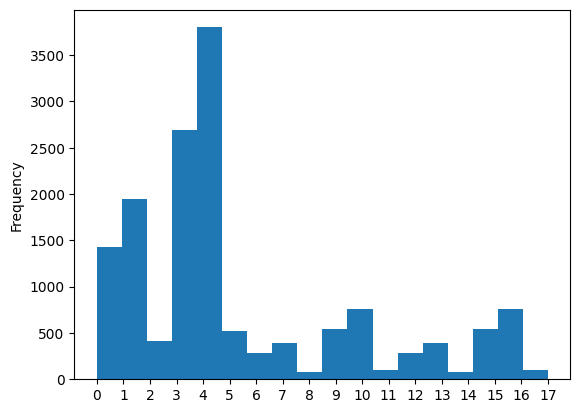

In [41]:
train_labels.plot.hist(bins=18, xticks=[i for i in range(18)])

In [6]:
import shutil
src = './9_T4064_Experiment_people_age.ipynb'
dst = './dataset/test2.ipynb'
shutil.copy(src,dst)

'./dataset/test2.ipynb'

In [5]:
!cp 9_T4064_Experiment_people_age.ipynb f'file_dir'

<AxesSubplot:ylabel='Frequency'>

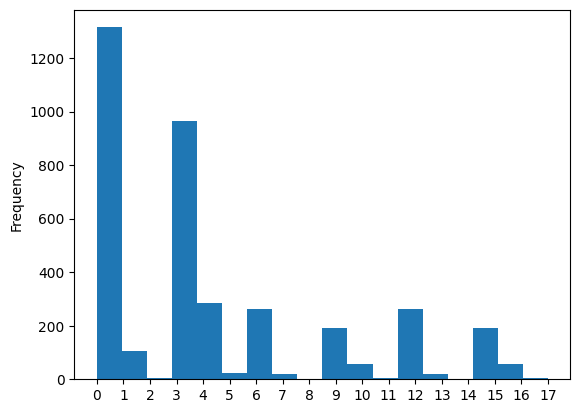

In [42]:
valid_labels.plot.hist(bins=18, xticks=[i for i in range(18)])

## 오류가 많았던 사람들 정리

In [1]:
import pandas as pd

csv1 = pd.read_csv('./checkpoints/gender_cls1/error_people.csv')
csv2 = pd.read_csv('./checkpoints/gender_cls2/error_people.csv')
csv3 = pd.read_csv('./checkpoints/gender_cls3/error_people.csv')

In [9]:
set1 = set(list(csv1['0'].values))
set2 = set(list(csv2['0'].values))
set3 = set(list(csv3['0'].values))


In [17]:
list(set.intersection(set1, set2, set3))

['006578_male_Asian_19',
 '006726_male_Asian_19',
 '006363_female_Asian_18',
 '006361_female_Asian_18',
 '006359_female_Asian_18',
 '006424_female_Asian_18',
 '006529_female_Asian_20',
 '005531_male_Asian_21',
 '006755_male_Asian_19',
 '006364_female_Asian_18',
 '006362_female_Asian_18',
 '006360_female_Asian_18',
 '006504_female_Asian_20',
 '006928_male_Asian_19']

## hard voting test

In [27]:
import numpy as np
import torch
from scipy.stats import mode
preds1 = torch.tensor([0,1,1])
preds2 = torch.tensor([2,1,0])
preds3 = torch.tensor([2,0,0])

In [28]:
combined = np.array([preds1.tolist(),preds2.tolist(),preds3.tolist()])
majority_vote = mode(combined)[0]

In [23]:
print(majority_vote)

[[[2 1 1]]]


In [29]:
preds1 = torch.tensor([0,1,1]).unsqueeze(dim=0)
preds2 = torch.tensor([2,1,0]).unsqueeze(dim=0)
preds3 = torch.tensor([2,0,1]).unsqueeze(dim=0)

t = torch.cat([preds1, preds2, preds3], dim=0)

In [25]:
voted = t.mode(0).values
print(voted)

tensor([2, 1, 1])


In [56]:
preds1 = torch.tensor([[0.,1.,1.,4]])
preds2 = torch.tensor([[2.,1.,0.,5]])
preds3 = torch.tensor([[2.,0.,0.,4]])

In [57]:
stacked = torch.cat([preds1, preds2, preds3], dim=0)

In [63]:
print(stacked.size())

torch.Size([3, 4])


In [62]:
print(torch.mean(stacked, axis=0))

tensor([1.3333, 0.6667, 0.3333, 4.3333])
